In [331]:
from sumolib import checkBinary
import xml.etree.ElementTree as ET
import traci
import sys
import random
import numpy as np


In [332]:
POPULAION_SIZE = 20
INTERMEDIATE_SIZE = 40
MUTATION_PERCENTAGE = 10
NO_OF_GENERATIONS = 100

In [333]:
waiting_times_data = []
accidents_data = []

In [334]:
class TrafficLightPattern:
    
    def __init__(self, genotype_size):
        self.size = genotype_size
        self.genotype = np.random.randint(2, size = genotype_size)
        self.phenotype = 0
        self.waiting_time = float('inf')
      
    def set_genotype(self, genotype):
        if len(genotype) == self.size:
            self.genotype = genotype
        else:
            print("Size error for the new genotype")
    
    def get_genotype(self):
        return self.genotype
    
    def set_phenotype(self, phenotype):
        self.phenotype = phenotype
    
    def get_phenotype(self):
        return self.phenotype
    
    def set_waiting_time(self, waiting_time):
        self.waiting_time = waiting_time
    
    def get_waiting_time(self):
        return self.waiting_time
    

In [335]:
def phenotype(genotype):
    '''return phenotype when gives a genotype'''
    phenotype = []
    m = ['G', 'g', 'y', 'r']
    
    for j in range(4):
        phenotype.append(int(''.join(map(str,genotype[:7])),2)) 

        state = genotype[7:47]
        s = ""
        for i in range(0, 20):
            s += m[int(str(state[2*i])+str(state[2*i+1]),2)]
        phenotype.append(s)

        genotype = genotype[47:]
    
    return phenotype

In [336]:
def simulate(program):
    '''return the waiting time after running the simulation'''
    
    traci.start([checkBinary(program), "-c", "sumo/light.sumocfg", "--tripinfo-output", "sumo/tripinfo.xml"])
    
    accidents = 0
    while traci.simulation.getMinExpectedNumber() > 0:
        traci.simulationStep()
        accidents += traci.simulation.getCollidingVehiclesNumber()
        
        
    traci.close()
    sys.stdout.flush()
    
    xmldoc = ET.parse('sumo/tripinfo.xml')

    tripinfos = xmldoc.findall('tripinfo')

    waiting_time = 0
    for tripinfo in tripinfos:
        waiting_time += float(tripinfo.get('waitingTime'))
        
    return waiting_time, accidents

In [337]:
def evaluate_pattern(phenotype):
    '''run the simulation after setting the new phenotype then return the waiting_time'''
    
    network = ET.parse('sumo/light.net.xml')
    signal = network.find('tlLogic') 
    
    i = 0
    for phase in signal.iter('phase'):
        
        duration = str(phenotype[2*i])
        if duration == "0":
             return float('inf'),0
        phase.set("duration", duration)
            
        state = phenotype[2*i+1]
        phase.set("state", state)
        i += 1
        
    network.write("sumo/light.net.xml")
    
    waiting_time,accidents = simulate('sumo')

    return waiting_time, accidents

In [338]:
def evaluate_population(population):
    times = []
    accident_list = []
    
    for pattern in population:
        waiting_time, accidents = evaluate_pattern(pattern.get_phenotype())
        pattern.set_waiting_time(waiting_time)
        times.append(waiting_time)
        accident_list.append(accidents)
        
    waiting_times_data.append(times)
    accidents_data.append(accident_list)

In [339]:
def create_new_population(population_size, genotype_size):
    
    population = []
    
    while (len(population) < population_size):
        light_pattern = TrafficLightPattern(genotype_size)
        if(not already_in(light_pattern, population)):
            light_pattern.set_phenotype(phenotype(light_pattern.get_genotype()))
            population.append(light_pattern)
            
    return population


In [340]:
def crossover(pattern_1, pattern_2):
    
    genotype_1 = np.copy(pattern_1.get_genotype())
    genotype_2 = np.copy(pattern_2.get_genotype())

    new_pattern = TrafficLightPattern(pattern_1.size)
    
    new_genotype = []
    
    for i in range(4):
        time = genotype_1[:7] if random.randint(1,100) > 50 else genotype_2[:7] 
        
        new_genotype = np.concatenate((new_genotype, time)).astype(int)
        for j in range(7,47,2):
            new_genotype = np.concatenate((new_genotype, genotype_1[j:j+2] if random.randint(1,100) > 50 else genotype_2[j:j+2])).astype(int)

        genotype_1 = genotype_1[47:]
        genotype_2 = genotype_2[47:]
        
    new_pattern.set_genotype(new_genotype)
    return new_pattern

In [341]:
def mutation(pattern):

    new_pattern = TrafficLightPattern(pattern.size)
    new_genotype = np.copy(pattern.get_genotype())
    
    how_much = random.randint(1,pattern.size)
    for i in range(how_much):
        index = random.choice(range(0,pattern.size))
        new_genotype[index] = not new_genotype[index] 
    new_pattern.set_genotype(new_genotype)
    return new_pattern

In [342]:
def already_in(new_genotype, population):
    return next((True for elem in population if np.array_equal(elem.get_genotype(), new_genotype.get_genotype())), False)

In [343]:
def select_candidates(population, size):
    population.sort(key = lambda x: x.get_waiting_time(), reverse=False)
    return population[0:size]

In [344]:
def next_generation(population, size, mutation_percentage):
    new_population = population
    while(len(new_population)<size):
        if (random.randint (1,100) > mutation_percentage):
            # do crossover 
            pattern1 = random.choice(new_population)
            pattern2 = random.choice(new_population)
            new_pattern = crossover(pattern1, pattern2)
            if(not already_in(new_pattern,new_population)):
                new_pattern.set_phenotype(phenotype(new_pattern.get_genotype()))
                new_population.append(new_pattern)
        
        else:
            # do mutation
            pattern = random.choice(new_population)
            new_pattern = mutation(pattern)
            if(not already_in(new_pattern,new_population)):
                new_pattern.set_phenotype(phenotype(new_pattern.get_genotype()))
                new_population.append(new_pattern)
            
    return new_population

In [345]:
def controller():
    genotype_size = 188
    population = create_new_population(POPULAION_SIZE,genotype_size)
    
    for i in range(NO_OF_GENERATIONS):
        next_gen = next_generation(population, INTERMEDIATE_SIZE, MUTATION_PERCENTAGE)
        evaluate_population(next_gen)
        population = select_candidates(next_gen,POPULAION_SIZE)
        print("Generation ",i," finished")
            
controller()

 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
Generation  0  finished
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying 

 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
Generation  8  finished
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying 

 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
Generation  17  finished
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying

 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
Generation  26  finished
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying

 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
Generation  34  finished
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying

 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
Generation  43  finished
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying

 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
Generation  52  finished
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying

 Retrying in 1 seconds
Generation  60  finished
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
Generation  61  finished
 Retryi

 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
Generation  69  finished
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying

 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
Generation  78  finished
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying

 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
Generation  87  finished
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying

 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
Generation  95  finished
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying

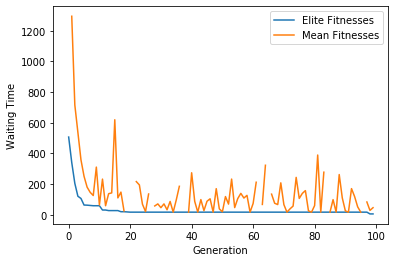

No handles with labels found to put in legend.


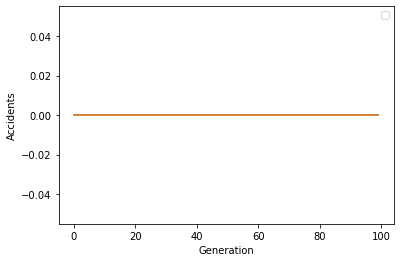

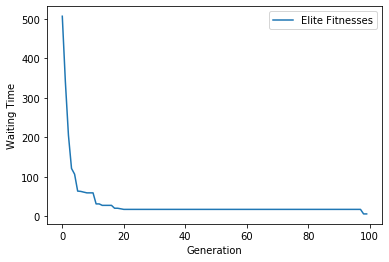

In [349]:
from statistics import mean, stdev
import matplotlib.pyplot as plt

'''Waiting time data'''

elite_fitnesses = []
mean_fitnesses = []
stdev_fitnesses = []

for i in waiting_times_data:
    elite_fitnesses.append(min(i))
    mean_fitnesses.append(mean(i))
    stdev_fitnesses.append(stdev(i))


plt.plot(elite_fitnesses,label='Elite Fitnesses')
plt.plot(mean_fitnesses,label='Mean Fitnesses')
# plt.plot(stdev_fitnesses,label='Standard Deviation')


plt.xlabel('Generation')
plt.ylabel('Waiting Time')
plt.legend()
plt.show()

'''Accident data'''

max_accidents = []
mean_accidents = []

for i in accidents_data:
    max_accidents.append(max(i))
    mean_accidents.append(mean(i))
    
plt.figure()

plt.plot(max_accidents)
plt.plot(mean_accidents)

plt.xlabel('Generation')
plt.ylabel('Accidents')
plt.legend()
plt.show()

'''Elite Graph'''

plt.figure()
plt.plot(elite_fitnesses,label='Elite Fitnesses')

plt.xlabel('Generation')
plt.ylabel('Waiting Time')
plt.legend()
plt.show()